# Data engineer

In [1]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-10-10 17:55:57          14073  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           8453  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           3770  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Women                               838MB  2021-02-28 14:56:00           1633  
dhruvildave/wikibooks-dataset                               Wikibooks Datase

In [7]:
#import kaggle datasets
!kaggle datasets download -d lavaman151/plantifydr-dataset

100% 2.57G/2.58G [00:35<00:00, 88.8MB/s]
100% 2.58G/2.58G [00:35<00:00, 78.0MB/s]


In [ ]:
!unzip plantifydr-dataset.zip

## data islemleri

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
from keras_preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

In [13]:
#EDA
len(os.listdir('/content/PlantDiseasesDataset/Tomato/train'))

10

In [21]:
train_datagen = ImageDataGenerator(zoom_range= 0.5, shear_range= 0.3, horizontal_flip= True, preprocessing_function= preprocess_input )
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [22]:
train = train_datagen.flow_from_directory(directory='/content/PlantDiseasesDataset/Tomato/train', 
                                          target_size=(256,256), batch_size=32)
val = train_datagen.flow_from_directory(directory='/content/PlantDiseasesDataset/Tomato/valid', 
                                          target_size=(256,256), batch_size=32)

Found 41763 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [23]:
t_img, label =train.next()

In [24]:
t_img.shape

(32, 256, 256, 3)

In [30]:
def plotImage(img_arr, label):

  for im, l in zip(img_arr, label):
    plt.figure(figsize=(5,5))
    plt.imshow(im/160)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


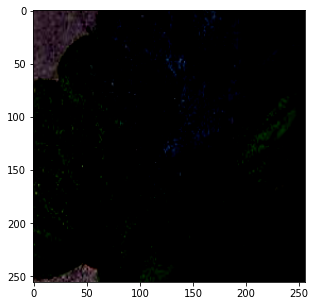

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


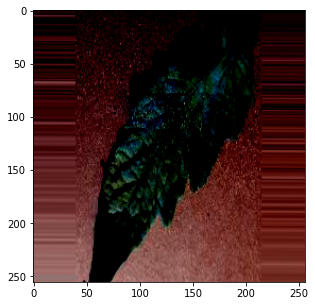

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


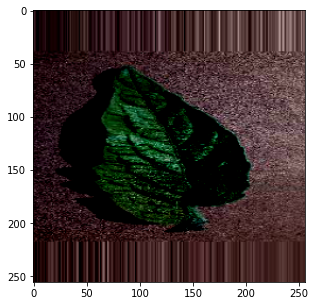

In [32]:
plotImage(t_img[:3], label[:3])

## building our model

In [35]:
from keras.layers import Dense, Flatten
from keras.models import Model 
from keras.applications.vgg19 import VGG19
import keras

In [36]:
base_model =VGG19(input_shape=(256,256,3), include_top= False)

80150528/80134624 [==============================] - 1s 0us/step


In [37]:
for layer in base_model.layers:
  layer.tranable = False

In [38]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [72]:
X = Flatten()(base_model.output)
#eda'da çıkan sayı 10 olduğu için units 10 olacak
X = Dense(units= 10, activation='softmax')(X)

#Creating our model
model = Model(base_model.input, X)

In [73]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [74]:
model.compile(optimizer='adam', loss= keras.losses.categorical_crossentropy, metrics= ['accuracy'])

## Early Stopping and Model Check point

In [75]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor= 'val_accuracy', min_delta= 0.01, patience= 3, verbose=1)

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', min_delta=0.01, patience= 3, verbose=1, save_best_only= True)

cb = [es, mc]

In [76]:
his = model.fit_generator(train, steps_per_epoch= 16, epochs= 50, verbose=1, callbacks= cb,
                          validation_data= val, validation_steps=16)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
16/16 [==============================] - 38s 2s/step - loss: 14.3904 - accuracy: 0.1250 - val_loss: 2.3656 - val_accuracy: 0.1200

Epoch 00001: val_accuracy improved from -inf to 0.12000, saving model to best_model.h5
Epoch 2/50
16/16 [==============================] - 19s 1s/step - loss: 2.2079 - accuracy: 0.1992
Epoch 3/50
16/16 [==============================] - 19s 1s/step - loss: 2.1584 - accuracy: 0.1992
Epoch 4/50
16/16 [==============================] - 19s 1s/step - loss: 2.1366 - accuracy: 0.2324
Epoch 5/50
16/16 [==============================] - 19s 1s/step - loss: 2.1068 - accuracy: 0.2031
Epoch 6/50
16/16 [==============================] - 19s 1s/step - loss: 1.9738 - accuracy: 0.2539
Epoch 7/50
16/16 [==============================] - 19s 1s/step - loss: 1.9085 - accuracy: 0.3066
Epoch 8/50
16/16 [==============================] - 19s 1s/step - loss: 1.9272 - accuracy: 0.3027
Epoch 9/50
16/16 [==============================] - 19s 1s/step - loss: 1.9993 - accu

In [78]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

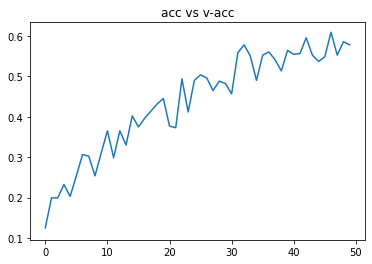

In [81]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")
plt.title("acc vs v-acc")
plt.show()

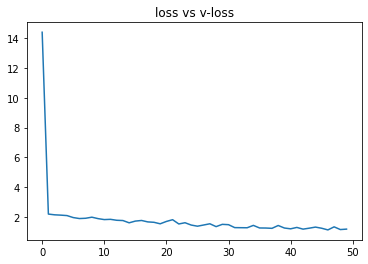

In [80]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = 'red')
plt.title("loss vs v-loss")
plt.show()

In [82]:
# load best model
from keras.models import  load_model

model = load_model("/content/best_model.h5")

In [83]:
acc = model.evaluate_generator(val)[1]

print(f"The accuracy of your model is {acc*100}%")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


The accuracy of your model is 11.999999731779099%


In [100]:
ref = dict(zip(list(train.class_indices.values()), list(train.class_indices.keys())))

In [104]:
def prediction(path):
  img = load_img(path, target_size=(256,256))
  i = img_to_array(img)
  im =preprocess_input(i)
  img =np.expand_dims(im, axis=0)

  pred = np.argmax(model.predict(img))

  print(f" The image belongs to { ref[pred] } ")

In [105]:
path = "/content/PlantDiseasesDataset/Tomato/train/Tomato Yellow Leaf Curl Virus/TomatoYellowCurlVirus(1).jpg"
prediction(path)

 The image belongs to Tomato Yellow Leaf Curl Virus 


In [95]:
train.class_indices

{'Tomato Bacterial spot': 0,
 'Tomato Early blight': 1,
 'Tomato Healthy': 2,
 'Tomato Late blight': 3,
 'Tomato Leaf Mold': 4,
 'Tomato Mosaic virus': 5,
 'Tomato Septoria leaf spot': 6,
 'Tomato Spider mites': 7,
 'Tomato Target Spot': 8,
 'Tomato Yellow Leaf Curl Virus': 9}